In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from einops import rearrange
import numpy as np
import matplotlib.pyplot as plt



def imshow(img_tensor, title):
    img_tensor = img_tensor[0]
    img = img_tensor.permute(1, 2, 0).detach().numpy()
    plt.imshow((img * 0.5) + 0.5)
    plt.title(title)
    plt.axis('off')



class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, second_path_size = None):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.embed_dim = embed_dim

        if second_path_size is None:
           self.second_path_size=patch_size//2
        else:
            self.second_path_size = second_path_size

        self.projection1 = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=self.second_path_size, stride=self.second_path_size)
        self.projection2 = nn.Conv2d(in_channels, embed_dim, kernel_size=self.second_path_size, stride=self.second_path_size)
        # self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=8, stride=8)
        # self.projection2 = nn.Conv2d(in_channels, embed_dim, kernel_size=2, stride=2)

    def forward(self, x):
        plt.figure(figsize=(15, 6))
        imshow(x, "ship-input")
        plt.tight_layout()
        plt.show()

        x1 = self.projection1(x)  # Shape: (B, embed_dim, H/patch_size, W/patch_size)

        # plt.figure(figsize=(15, 6))
        # imshow(x1, "ship-after first projection")
        # plt.tight_layout()
        # plt.show()

        x1 = rearrange(x1, "b c h w -> b (h w) c")  # Shape: (B, num_patches, embed_dim)
        # print(f'hereX1 {x1.shape}')


        x2 = self.conv(x)  # Downsample input
        plt.figure(figsize=(15, 6))
        imshow(x2, "ship-after conv")
        plt.tight_layout()
        plt.show()
        x2 = self.projection2(x2)  # Shape: (B, embed_dim, H/(patch_size/2), W/(patch_size/2))
        # plt.figure(figsize=(15, 6))
        # imshow(x1, "ship-after second projection")
        # plt.tight_layout()
        # plt.show()
        x2 = rearrange(x2, "b c h w -> b (h w) c")  # Shape: (B, num_patches, embed_dim)
        # print(f'hereX2 {x2.shape}')

        x = torch.cat((x1, x2), dim=1)  # Shape: (B, 2*num_patches, embed_dim)
        # print(f'hereX3 {x.shape}')
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, dim, num_heads, print_w=False):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.q_proj1 = nn.Linear(dim, dim)
        self.q_proj2 = nn.Linear(dim, dim)

        self.k_proj1 = nn.Linear(dim, dim)
        self.k_proj2 = nn.Linear(dim, dim)

        self.fc_out = nn.Linear(dim, dim)

        self.weights = nn.Parameter(torch.randn(4))

        self.v_proj1 = nn.Linear(dim, dim)
        self.v_proj2 = nn.Linear(dim, dim)

        self.print_w=print_w

    def forward(self, x):
        B, M, C = x.shape
        N= (M-2)//2

        q1 = self.q_proj1(x[:, :N + 1])
        q1 = rearrange(q1, "b n (h d) -> b h n d", h=self.num_heads, d=self.head_dim)
        q2 = self.q_proj2(x[:, N + 1:])
        q2 = rearrange(q2, "b n (h d) -> b h n d", h=self.num_heads, d=self.head_dim)

        k1 = self.k_proj1(x[:, :N + 1])
        k1 = rearrange(k1, "b n (h d) -> b h n d", h=self.num_heads, d=self.head_dim)
        k2 = self.k_proj2(x[:, N + 1:])
        k2 = rearrange(k2, "b n (h d) -> b h n d", h=self.num_heads, d=self.head_dim)

        q = torch.cat((q1, q2), dim=2)
        k = torch.cat((k1, k2), dim=2)

        # print(N)
        # print(M)

        # print(x[:,:N +1].shape)
        # print(x[:,N +1:].shape)

        v1 = self.v_proj1(x[:, :N + 1])
        # print(v1.shape)
        v1 = rearrange(v1, "b n (h d) -> b h n d", h=self.num_heads, d=self.head_dim)

        v2 = self.v_proj2(x[:, N + 1:])
        # print(v2.shape)
        v2 = rearrange(v2, "b n (h d) -> b h n d", h=self.num_heads, d=self.head_dim)


        attn = torch.einsum("bhqd, bhkd -> bhqk", q, k) * self.scale  # Shape: (B, h, 2N, 2N)

        # N = (attn.shape[-1] - 2) // 2
        block1 = attn[:, :, :N + 1, :N + 1]
        block2 = attn[:, :, :N + 1, N + 1:]
        block3 = attn[:, :, N + 1:, :N + 1]
        block4 = attn[:, :, N + 1:, N + 1:]

        block1 = block1.softmax(dim=-1)
        block2 = block2.softmax(dim=-1)
        block3 = block3.softmax(dim=-1)
        block4 = block4.softmax(dim=-1)

        w = F.gumbel_softmax(self.weights, tau=1.0, hard=True, dim=0)

        if self.print_w:
            # print(w)
            print(torch.argmax(self.weights)+1)            

        attn = w[0] * block1 + w[1] * block2 + w[2] * block3 + w[3] * block4

        # print(attn.shape)
        # print(v1.shape, v2.shape)
        out1 = torch.einsum("bhqk, bhkd -> bhqd", attn, v1)  # Shape: (B, h, N, d)
        out2 = torch.einsum("bhqk, bhkd -> bhqd", attn, v2)  # Shape: (B, h, N, d)
        out = torch.cat((out1, out2), dim=2)  # Shape: (B, h, 2N, d)
        out = rearrange(out, "b h n d -> b n (h d)")  # Shape: (B, 2N, C)

        return self.fc_out(out)

class MLP(nn.Module):
    def __init__(self, dim, hidden_dim, dropout):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, dim)
        self.dropout = nn.Dropout(dropout)
        self.act = nn.GELU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_dim, dropout, print_w = False):
        super(TransformerBlock, self).__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.attn = MultiHeadAttention(dim, num_heads, print_w=print_w)
        self.mlp = MLP(dim, mlp_dim, dropout)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10, dim=64, depth=6, heads=8, mlp_dim=128, dropout=0.1, second_path_size = None, print_w=False):
        super(VisionTransformer, self).__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, dim, second_path_size)
        self.cls_token1 = nn.Parameter(torch.randn(1, 1, dim))
        self.cls_token2 = nn.Parameter(torch.randn(1, 1, dim))
        self.positional_encoding = nn.Parameter(torch.randn(1, (2 * (img_size // patch_size) ** 2) + 2, dim))
        self.transformer = nn.ModuleList([
            TransformerBlock(dim, heads, mlp_dim, dropout, print_w=print_w)
            for _ in range(depth)
        ])
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(2*dim),
            nn.Linear(2*dim, num_classes)
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens1 = self.cls_token1.expand(B, -1, -1)
        cls_tokens2 = self.cls_token2.expand(B, -1, -1)
        middle_idx = x.shape[1] // 2
        x = torch.cat((cls_tokens1, x[:, :middle_idx], cls_tokens2, x[:, middle_idx:]), dim=1)
        x += self.positional_encoding

        for block in self.transformer:
            x = block(x)

        cls_output1 = x[:, 0]
        cls_output2 = x[:, middle_idx + 1]
        combined_cls_output = torch.cat((cls_output1, cls_output2), dim=1)
        return self.mlp_head(combined_cls_output)


In [2]:
model = VisionTransformer()

In [3]:
import sys
sys.path.append('..')

import torch
import matplotlib.pyplot as plt
from Utils.cifar10_loaders import get_cifar10_dataloaders

train_loader, test_loader = get_cifar10_dataloaders(image_size=32, batch_size=1)

train_dataset = train_loader.dataset
test_dataset = test_loader.dataset

classes = train_dataset.dataset.classes if hasattr(train_dataset, 'dataset') else train_dataset.classes
num_classes = len(classes)

print("Dataset: CIFAR-10")
print(f"Number of classes: {num_classes}")
print(f"Class names: {classes}")
print(f"Train set size: {len(train_dataset)}")
print(f"Test set size: {len(test_dataset)}")

for i in range(5000):
   images, labels = next(iter(train_loader))
#image, label = train_loader[40094]

print(images.shape,labels)

Dataset: CIFAR-10
Number of classes: 10
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train set size: 50000
Test set size: 10000
torch.Size([1, 3, 32, 32]) tensor([6])


In [4]:
import os
# TEST_ID = 
# epoch = 
# weights_path = os.path.join('../results',TEST_ID, 'model_stats', f'Model_epoch_{epoch}.pth')
print(model.load_state_dict(torch.load('Model_epoch_195.pth')))

<All keys matched successfully>


In [55]:
import torchvision
a = torchvision.io.read_image('plane.png')
a = a.float() / 255.0   

In [56]:
a = a.unsqueeze(0)
a.shape

torch.Size([1, 3, 32, 32])

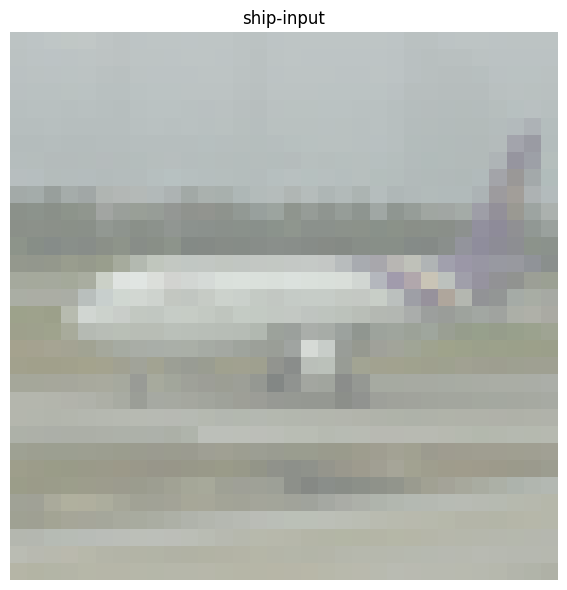

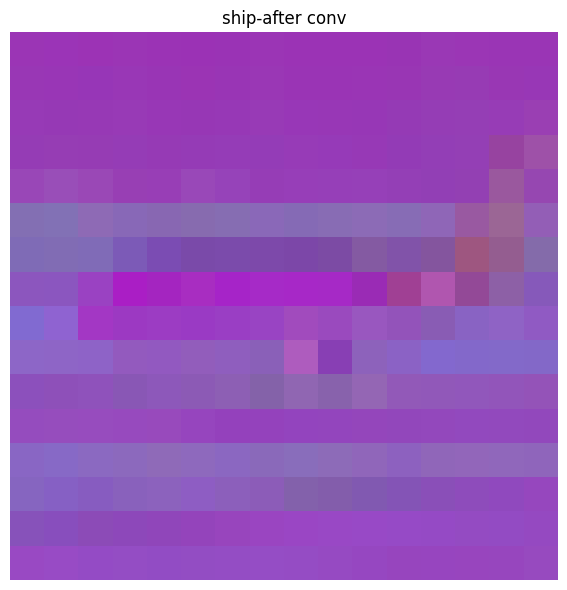

tensor([[ 2.3017, -8.5368,  1.3504,  2.2782,  5.0099, -0.3721, -4.2033, -9.0479,
          2.9275, -0.9320]], grad_fn=<AddmmBackward0>)

In [57]:
model(a)